# Euler's method for solving ODEs

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (15,10)

The ODE we want to solve is $$\frac{dy}{dx} = -2x - y$$ with initial conditions $x_0 = 0, y_0 = -1$. We have chosen this test case as it has a simlpe analytic solution we can compare against $y(x) = -3e^{-x} -2x +2$

In [3]:
def dydx(x,y):
    return -2*x - y

In [22]:
def yExact(x):
    return - 3*np.exp(-x) - 2*x + 2

In [76]:
def EulerMethod(dydx, yExact, dx, x0, y0, imax, printSteps=False, plotSteps=False):
    i = 0
    xi = x0
    yi = y0
    
    if(plotSteps):
            plt.scatter(x0, y0, color='red', linewidth='10')
    
    # Create a loop to iteratively solve the ODE step-by-step
    while i < imax:
        # The next three lines implement the Euler method
        fi = dydx(xi, yi)
        xi += dx
        yi = yi + dx*fi
        i += 1
        
        if(printSteps):
            diffi = yi - yExact(xi)
            Ei    = np.abs(100*diffi/yExact(xi))
            print("%d %.2f %.5f %.4f %.2f" % (i, xi, yi, diffi, Ei))
            
        if(plotSteps):
            plt.scatter(xi, yi, color='red', linewidth='10')
 
    if(plotSteps):
        x = np.linspace(x0, x0 + imax*dx, 100)
        y = yExact(x)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)
        plt.plot(x,y)
    return yi

1 0.10 -0.90000 0.0145 1.59
2 0.20 -0.83000 0.0262 3.06
3 0.30 -0.78700 0.0355 4.31
4 0.40 -0.76830 0.0427 5.26
5 0.50 -0.77147 0.0481 5.87


-0.77147

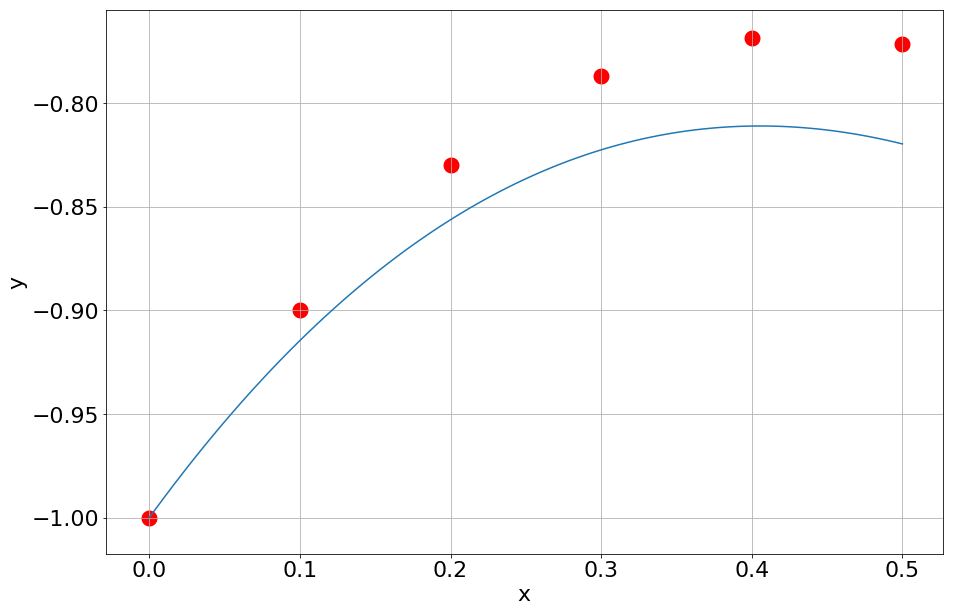

In [77]:
EulerMethod(dydx, yExact, 0.1, 0, -1, 5, True, True)